In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

from constraints import (
    epsilon,
    p,
    pQCD_likelihood,
    pQCD_constraints
)

from utils import (
    rcparams,
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre
    )

plt.rcParams.update(rcparams)

In [2]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values

CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

# Keys are different values for the renormalization scale parameter X
pQCD_values = {
    1: [2.6, 6.14, 2334/1000],
    2: [2.6, 6.47, 3823/1000],
    4: [2.6, 6.87, 4284/1000]
}

# Nuclear saturation density
nsat = 0.16

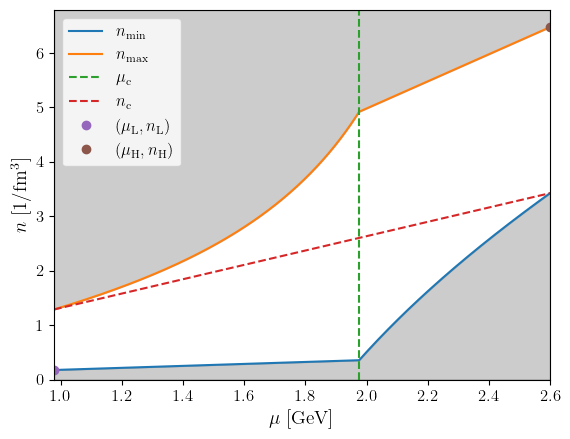

In [3]:
muL, nL, pL = CET_values['stiff']
muH, nH, pH = pQCD_values[2]

mu_array = np.linspace(muL, muH, 1000)

epsilonL = epsilon(muL, nL, pL)
epsilonH = epsilon(muH, nH, pH)

constraints = pQCD_constraints(muL, nL, pL, muH, nH, pH)
fig, ax = constraints.plot_mu_n(mu_array)

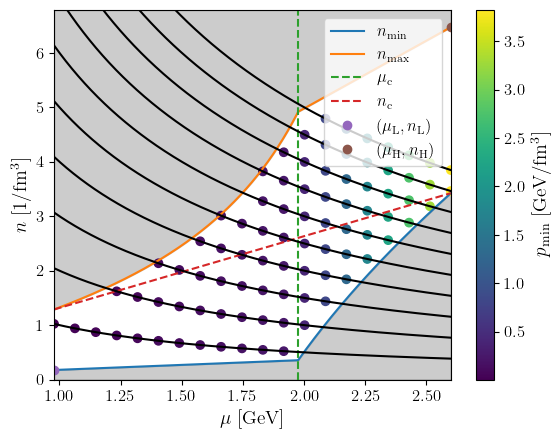

In [4]:
fig, ax = constraints.plot_mu_n(mu_array)

# Overplot some constant-enthalpy lines
h_array = np.linspace(1, 10, 10)

for h in h_array:
    ax.plot(mu_array, h/mu_array, c='k')

# Indicate the minimum pressure along each constant-enthalpy line
reduced_mu_array = np.linspace(muL, muH, 20)
reduced_n_array = np.outer(h_array, 1/reduced_mu_array).flatten()

reduced_mu_array_scatter = np.outer(np.ones(len(h_array)), reduced_mu_array).flatten()

mask = (
    (constraints.nmin(reduced_mu_array_scatter) < reduced_n_array) & 
    (reduced_n_array < constraints.nmax(reduced_mu_array_scatter))
)

im = ax.scatter(
    reduced_mu_array_scatter[mask],
    reduced_n_array[mask],
    c=constraints.pmin(reduced_mu_array_scatter)[mask], 
    cmap='viridis'
    )

cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{min}$ [GeV/fm$^3$]')

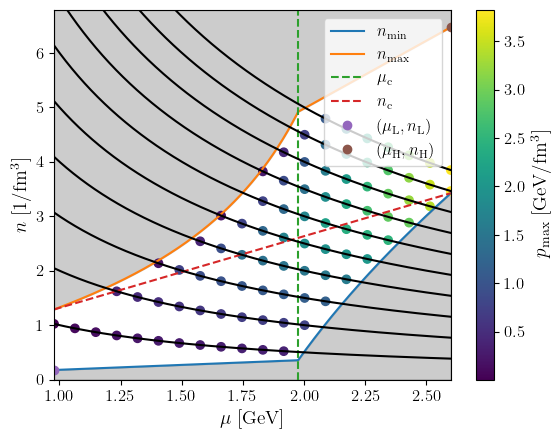

In [5]:
fig, ax = constraints.plot_mu_n(mu_array)

# Overplot some constant-enthalpy lines
h_array = np.linspace(1, 10, 10)

for h in h_array:
    ax.plot(mu_array, h/mu_array, c='k')

# Indicate the maximum pressure along each constant-enthalpy line
reduced_mu_array = np.linspace(muL, muH, 20)
reduced_n_array = np.outer(h_array, 1/reduced_mu_array).flatten()

reduced_mu_array_scatter = np.outer(np.ones(len(h_array)), reduced_mu_array).flatten()

mask = (
    (constraints.nmin(reduced_mu_array_scatter) < reduced_n_array) & 
    (reduced_n_array < constraints.nmax(reduced_mu_array_scatter))
)

im = ax.scatter(
    reduced_mu_array_scatter[mask],
    reduced_n_array[mask],
    c=constraints.pmax(reduced_mu_array_scatter, reduced_n_array)[mask], 
    cmap='viridis'
    )

cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{max}$ [GeV/fm$^3$]')

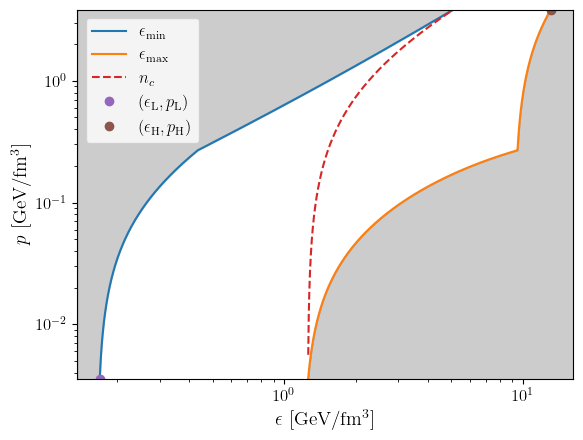

In [6]:
fig, ax = constraints.plot_epsilon_p(mu_array)

In [7]:
df = pd.read_csv('collated_np_all_post.csv')
nonzero_eos = df[df.logweight_total > -np.inf]

nTOV_array = to_nucleons_per_cubic_femtometre(nonzero_eos['rhoc(M@Mmax)'])

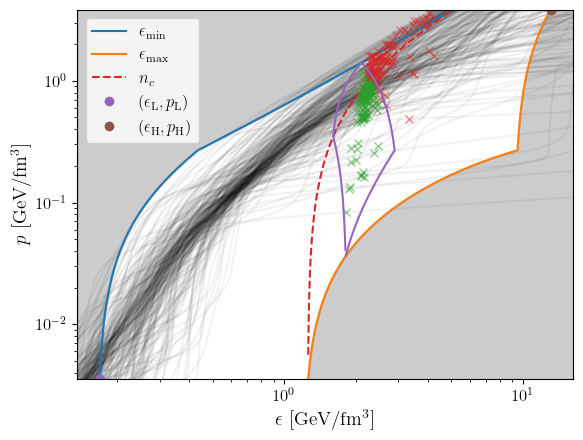

In [27]:
fig, ax = constraints.plot_epsilon_p(mu_array)

# Overplot some EOS draws, and visualise the pQCD likelihood when applied at n0
n0 = 10*nsat

# A list of allowed EOSs will be useful
good_eos_list = []

N_samp = 250
for eos in nonzero_eos.eos[:N_samp]:

    eos = int(eos)
    df = pd.read_csv(f'eos-draws/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.05, 
        c='k',
        zorder=0.1
        )
    
    highlight_index = np.argmin((number_density-n0)**2)

    allowed = pQCD_likelihood(energy_density[highlight_index], pressure[highlight_index], n0, 2)
    if allowed:
        good_eos_list.append((
            pressure.values[:highlight_index], 
            energy_density.values[:highlight_index], 
            number_density.values[:highlight_index]
            ))

    ax.plot(
        energy_density[highlight_index],
        pressure[highlight_index],
        'x',
        c='C2' if allowed else 'C3',
        alpha=0.5
        )

# Indicate the allowed region at this density
x1 = epsilon(mu_array, n0, constraints.pmax(mu_array, n0))
x2 = epsilon(mu_array, n0, constraints.pmin(mu_array))
mask = x1 < x2

ax.plot(
    x1[mask], 
    constraints.pmax(mu_array, n0)[mask], 
    c='C4'
    )

_ = ax.plot(
    x2[mask], 
    constraints.pmin(mu_array)[mask], 
    c='C4'
    )

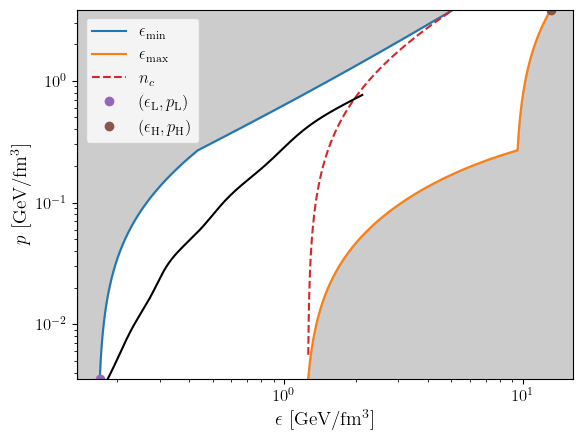

In [84]:
i = 12
pressure, energy_density, number_density = good_eos_list[i]
chemical_potential = (energy_density+pressure)/number_density

fig, ax = constraints.plot_epsilon_p(mu_array)

_ = ax.plot(
    energy_density,
    pressure,
    'k'
    )

In [85]:
# The area under the curve:
p(chemical_potential, number_density, pressure[0])[-1]

0.7628859287286452

In [86]:
# Should be equal to the pressure at the end of the curve:
pressure[-1]

0.7641868306448046

In [87]:
# And the requested number density:
n0

0.8

In [88]:
# Should equal the final number density of the curve:
number_density[-1]

1.5558799801621002

In [89]:
# We effectively have new low-density values. This will inform the available 
# parameter space for higher densities
new_constraints = pQCD_constraints(chemical_potential[-1], number_density[-1], pressure[-1], muH, nH, pH)
new_mu_array = np.linspace(chemical_potential[-1], muH, 1000)

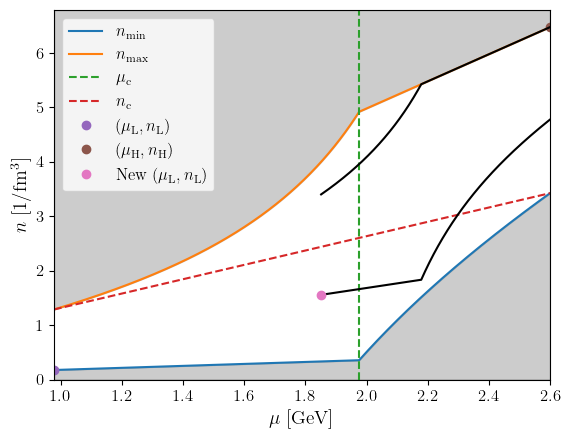

In [90]:
fig, ax = constraints.plot_mu_n(mu_array)

ax.plot(new_mu_array, new_constraints.nmin(new_mu_array), c='k')
ax.plot(new_mu_array, new_constraints.nmax(new_mu_array), c='k')

ax.plot(
    new_constraints.muL, 
    new_constraints.nL, 
    'o', 
    c='C6', 
    label='New $(\mu_\mathrm{L}, n_\mathrm{L})$'
    )

_ = ax.legend()

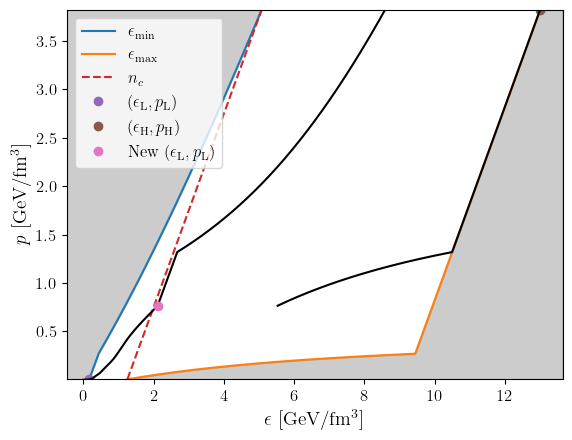

In [91]:
fig, ax = constraints.plot_epsilon_p(mu_array, log=False)

ax.plot(
    energy_density,
    pressure,
    'k'
    )

ax.plot(
    new_constraints.epsilon_min(new_mu_array), 
    new_constraints.pmax(new_mu_array, new_constraints.nmin(new_mu_array)), 
    c='k',
    )
ax.plot(
    new_constraints.epsilon_max(new_mu_array), 
    new_constraints.pmin(new_mu_array), 
    c='k',
    )

ax.plot(
    new_constraints.epsilonL, 
    new_constraints.pL, 
    'o', 
    c='C6', 
    label='New $(\epsilon_\mathrm{L}, p_\mathrm{L})$'
    )

_ = ax.legend()

In [93]:
with open('../komoltsev/qcd-likelihood-with-marginalization/eos_extensions_s-G-1p25-0p25_l-U-1-20_meancs2-G-0.3-0.3_pQCD-25-40.pickle', 'rb') as f:
    eos_extensions = pickle.load(f)

In [94]:
eos_extensions['n'] = (eos_extensions['p'] + eos_extensions['e'])/eos_extensions['mu']

In [105]:
len(eos_extensions)

10000

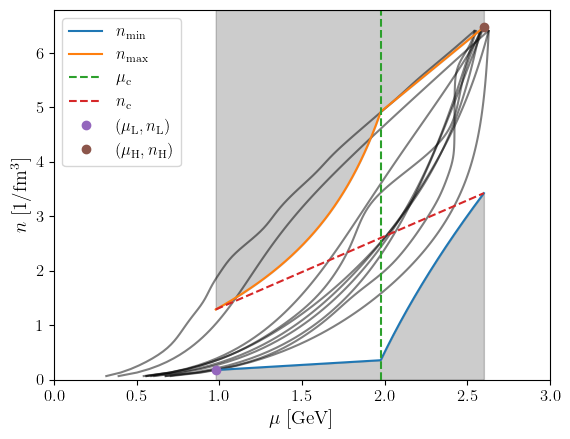

In [128]:
fig, ax = constraints.plot_mu_n(mu_array)

N_samp = 10
for index, eos in eos_extensions.sample(N_samp).iterrows():
    ax.plot(eos.mu, eos.n, 'k', alpha=0.5, zorder=0.01)

ax.set_xlim(0, 3)
_ = ax.legend(loc='upper left')

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_3426/833109061.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-3, 15)
/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_3426/833109061.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(-5, 5)


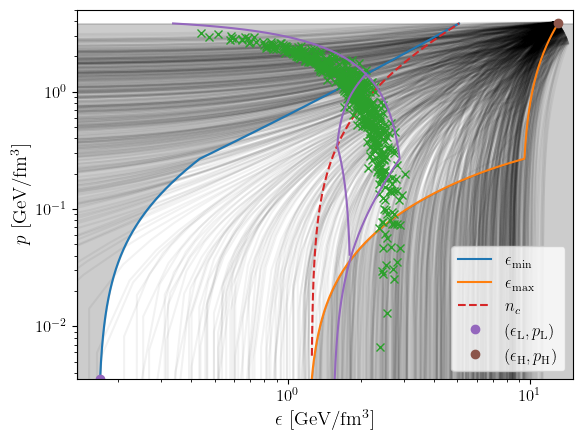

In [150]:
fig, ax = constraints.plot_epsilon_p(mu_array, log=True)

n0 = 10*nsat
N_samp = 1000
for index, eos in eos_extensions.sample(N_samp).iterrows():
    ax.plot(eos.e, eos.p, 'k', alpha=0.05, zorder=0.01)
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    ax.plot(eos.e[highlight_index], eos.p[highlight_index], 'x', c='C2')

ax.set_xlim(-3, 15)
ax.set_ylim(-5, 5)

# Indicate the allowed region at this density
x1 = epsilon(mu_array, n0, constraints.pmax(mu_array, n0))
x2 = epsilon(mu_array, n0, constraints.pmin(mu_array))
mask = x1 < x2

ax.plot(
    x1[mask], 
    constraints.pmax(mu_array, n0)[mask], 
    c='C4'
    )

_ = ax.plot(
    x2, 
    constraints.pmin(mu_array), 
    c='C4'
    )

_ = ax.legend(loc='lower right')